## Imports

In [214]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from sklearn import metrics

In [215]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [218]:
df_lapil42 = pd.read_csv('data/polynomial_lapil42_selected_df.csv')
df_lapil42_all = pd.read_csv('data/polynomial_lapil42_allweather_df.csv')

## Feature engineering

Nous allons transformer la colonne speed de façon catégorielle : au dessus de 75, le trafic est fluide (1), sinon le trafic est congestionné (0) : 

In [392]:
def etat_du_trafic(x):
    if x > 80: return 0
    else: return 1

Nous ajoutons la variable à prédire : l'état du trafic dans 30 minutes

In [393]:
df_lapil42['congestion+30min'] = df_lapil42['speed'].shift(periods=-5, fill_value=False).apply(lambda x : etat_du_trafic(x))

In [394]:
df_lapil42['congestion+30min'].value_counts()

0    5275
1    1445
Name: congestion+30min, dtype: int64

In [395]:
df_lapil42_all['congestion+30min'] = df_lapil42_all['speed'].shift(periods=-5, fill_value=False).apply(lambda x : etat_du_trafic(x))

In [396]:
df_lapil42_all['congestion+30min'].value_counts()

0    5275
1    1445
Name: congestion+30min, dtype: int64

## Création des différents jeux de données

In [397]:
Df = df_lapil42.drop(['congestion+30min', 'date'], axis = 1)

In [398]:
Df_all = df_lapil42_all.drop(['congestion+30min', 'date'], axis = 1)

In [399]:
y = df_lapil42['congestion+30min']

In [400]:
def split_vals(df, n): 
    return df[:n].copy(), df[n:].copy()

In [401]:
n_total = len(df_lapil42)
n_test = 1500 #arbitrary
n_train = n_total - n_test

In [402]:
X_train_all, X_valid_all = split_vals(Df_all, n_train)
X_train, X_valid = split_vals(Df, n_train)
y_train, y_valid = split_vals(y, n_train)

print('Number of full training data points: X = {}, y = {}'.format(X_train.shape, y_train.shape))
print('Number of validation data points: X = {}, y = {}'.format(X_valid.shape, y_valid.shape))

Number of full training data points: X = (5220, 33), y = (5220,)
Number of validation data points: X = (1500, 33), y = (1500,)


In [403]:
y_valid.value_counts()

0    1204
1     296
Name: congestion+30min, dtype: int64

In [404]:
y_train.value_counts()

0    4071
1    1149
Name: congestion+30min, dtype: int64

## Premier modèle

In [405]:
classifier = RandomForestClassifier(
    n_estimators = 20, 
    class_weight = None, # classifier specific
    criterion = 'gini',  # classifier specific
    max_depth = 3, 
    min_samples_split = 2, 
    min_samples_leaf = 1, 
    min_weight_fraction_leaf = 0.0, 
    max_features = 'auto', 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    min_impurity_split = None, 
    ccp_alpha = 0.0, 
    random_state = 42, 
    bootstrap = True, 
    oob_score = True, 
    max_samples = None,
    warm_start = False, 
    n_jobs = -1, 
    verbose = 0, 
)

In [406]:
def classifier_metrics (y_test, y_preds, average='weighted'):
    """Return Accuracy, Recall, Precision and F-1 score. 
    Average can take two arguments : macro or weighted """

    acc = metrics.accuracy_score(y_test, y_preds)
    rec = metrics.recall_score(y_test, y_preds, sample_weight = None)
    prc = metrics.precision_score(y_test, y_preds, sample_weight = None)
    f1  = metrics.f1_score(y_test, y_preds, sample_weight = None)

    print('Accuracy : {:.2f}%'.format(acc*100))
    print('Recall : {:.2f}%'.format(rec*100))
    print('Precision : {:.2f}%'.format(prc*100))
    print('F1-score : {:.2f}%'.format(f1*100))

In [407]:
classifier.fit(X_train_all, y_train)
classifier_metrics(y_train, classifier.predict(X_train_all))

Accuracy : 90.65%
Recall : 60.31%
Precision : 95.59%
F1-score : 73.96%


/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [408]:
classifier.fit(X_train, y_train)
classifier_metrics(y_train, classifier.predict(X_train))

Accuracy : 90.25%
Recall : 57.27%
Precision : 97.34%
F1-score : 72.11%


/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/anaconda3/envs/fastai-cpu-v0.7/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Les résultats sont plutôt bons mais peuvent certainement être améliorer. Procédons au tuning des hyperparamètres :

## Tuning des hyperparamètres :

Le jeu de données dont nous disposons est plutôt restreint. Nous allons donc travailler uniquement sur l'échantillon "train" grâce à des Cross-validation :

### Déterminons le nombre d'estimateurs le plus pertinent

In [409]:
def plt_f1(start, end, pas):
    f1_results = []
    f1_results_all = []
    
    for k in range(start, end, pas):
        classifier = RandomForestClassifier(
            n_estimators = k, 
            class_weight = None, # classifier specific
            criterion = 'gini',  # classifier specific
            max_depth = 3, 
            min_samples_split = 2, 
            min_samples_leaf = 1, 
            min_weight_fraction_leaf = 0.0, 
            max_features = 'auto', 
            max_leaf_nodes = None, 
            min_impurity_decrease = 0.0, 
            min_impurity_split = None, 
            ccp_alpha = 0.0, 
            random_state = 42, 
            bootstrap = True, 
            oob_score = False, 
            max_samples = None,
            warm_start = False, 
            n_jobs = -1, 
            verbose = 0, 
        )

        classifier.fit(X_train, y_train)
        mean_score = cross_val_score(classifier, X_train, y_train, scoring="f1", cv = 7).mean()

        classifier.fit(X_train_all, y_train)
        mean_score_all = cross_val_score(classifier, X_train_all, y_train, scoring = 'f1', cv = 7).mean()
        f1_results.append(mean_score)
        f1_results_all.append(mean_score_all)

    plt.plot(f1_results)
    plt.plot(f1_results_all)
    print('Météo réduite :')
    print([(k,v) for k,v in zip(f1_results, range(start,end,pas))])
    print('   ')
    print('Météo complète')
    print([(k,v) for k,v in zip(f1_results_all, range(start,end,pas))])

Météo réduite :
[(0.5805999795018992, 40), (0.5902261143515567, 45), (0.5923248006933916, 50), (0.5792649154749342, 55), (0.604753350536617, 60), (0.603438170520061, 65), (0.6030610021355493, 70), (0.5975413739678306, 75)]
   
Météo complète
[(0.5872514727231913, 40), (0.5903799270019293, 45), (0.5737024552922314, 50), (0.5783263122908243, 55), (0.6041922178714227, 60), (0.608035349623551, 65), (0.6101103325233387, 70), (0.5989072424619215, 75)]


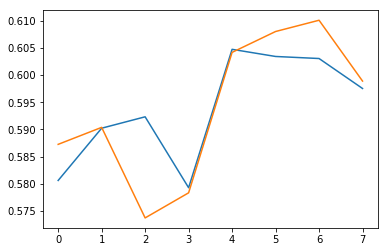

In [410]:
plt_f1(40,80,5)

Gardons 60 comme valeurs.

### Déterminons la taille des arbres

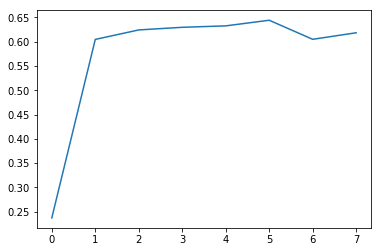

In [411]:
f1_results = []
for k in range(2, 10, 1):
    classifier = RandomForestClassifier(
        n_estimators = 60, 
        class_weight = None, # classifier specific
        criterion = 'gini',  # classifier specific
        max_depth = k, 
        min_samples_split = 2, 
        min_samples_leaf = 1, 
        min_weight_fraction_leaf = 0.0, 
        max_features = 'auto', 
        max_leaf_nodes = None, 
        min_impurity_decrease = 0.0, 
        min_impurity_split = None, 
        ccp_alpha = 0.0, 
        random_state = 42, 
        bootstrap = True, 
        oob_score = False, 
        max_samples = None,
        warm_start = False, 
        n_jobs = -1, 
        verbose = 0, 
    )
    
    classifier.fit(X_train, y_train)
    mean_score = cross_val_score(classifier, X_train, y_train, scoring="f1", cv = 7).mean()
    f1_results.append(mean_score)
    
plt.plot(f1_results)

In [412]:
[(k,v) for k,v in zip(f1_results, range(2,10,1))]

[(0.2372402273597591, 2),
 (0.604753350536617, 3),
 (0.6242543311207226, 4),
 (0.6296712213577796, 5),
 (0.6326266105377011, 6),
 (0.6442049843318524, 7),
 (0.6049652993716081, 8),
 (0.6183952857612558, 9)]

In [413]:
y_train.value_counts()

0    4071
1    1149
Name: congestion+30min, dtype: int64

In [414]:
[(k,v) for k,v in zip(f1_results, range(2,10,1))]

[(0.2372402273597591, 2),
 (0.604753350536617, 3),
 (0.6242543311207226, 4),
 (0.6296712213577796, 5),
 (0.6326266105377011, 6),
 (0.6442049843318524, 7),
 (0.6049652993716081, 8),
 (0.6183952857612558, 9)]

Gardons 5 comme valeurs.

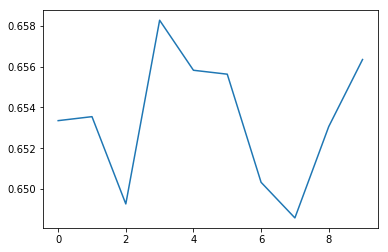

In [280]:
#0.73
f1_results = []
for k in range(50, 70, 2):
    classifier = RandomForestClassifier(
        n_estimators = 60, 
        class_weight = None, # classifier specific
        criterion = 'gini',  # classifier specific
        max_depth = 5, 
        min_samples_split = k, 
        min_samples_leaf = 1, 
        min_weight_fraction_leaf = 0.0, 
        max_features = 'auto', 
        max_leaf_nodes = None, 
        min_impurity_decrease = 0.0, 
        min_impurity_split = None, 
        ccp_alpha = 0.0, 
        random_state = 42, 
        bootstrap = True, 
        oob_score = False, 
        max_samples = None,
        warm_start = False, 
        n_jobs = -1, 
        verbose = 0, 
    )
    
    classifier.fit(X_train, y_train)
    mean_score = cross_val_score(classifier, X_train, y_train, scoring="f1", cv = 7).mean()
    f1_results.append(mean_score)
    
plt.plot(f1_results)

In [281]:
[(k,v) for k,v in zip(f1_results, range(50,70,2))]

[(0.6533498724222362, 50),
 (0.6535454175629661, 52),
 (0.6492641359934481, 54),
 (0.658275072887036, 56),
 (0.6558214807763463, 58),
 (0.6556290900621208, 60),
 (0.6503251721781531, 62),
 (0.6485780282339635, 64),
 (0.6530561646074453, 66),
 (0.6563482102308578, 68)]

Gardons 58.

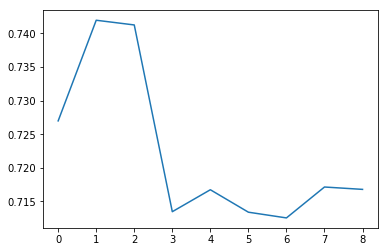

In [154]:
f1_results = []
for k in range(1, 10, 1):
    classifier = RandomForestClassifier(
        n_estimators = 60, 
        class_weight = None, # classifier specific
        criterion = 'gini',  # classifier specific
        max_depth = 5, 
        min_samples_split = 58, 
        min_samples_leaf = k, 
        min_weight_fraction_leaf = 0.0, 
        max_features = 'auto', 
        max_leaf_nodes = None, 
        min_impurity_decrease = 0.0, 
        min_impurity_split = None, 
        ccp_alpha = 0.0, 
        random_state = 42, 
        bootstrap = True, 
        oob_score = False, 
        max_samples = None,
        warm_start = False, 
        n_jobs = -1, 
        verbose = 0, 
    )
    
    classifier.fit(X_train, y_train)
    mean_score = cross_val_score(classifier, X_train, y_train, scoring="f1", cv = 7).mean()
    f1_results.append(mean_score)
    
plt.plot(f1_results)

Gardons la valeur par défaut : 1

### "max features"

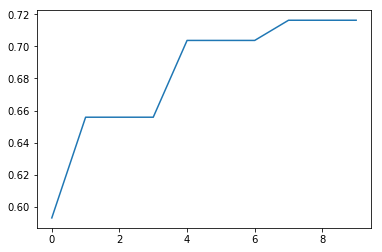

In [282]:
f1_results = []
for k in range(15, 25, 1):
    classifier = RandomForestClassifier(
        n_estimators = 60, 
        class_weight = None, # classifier specific
        criterion = 'gini',  # classifier specific
        max_depth = 5, 
        min_samples_split = 58, 
        min_samples_leaf = 1, 
        min_weight_fraction_leaf = 0.0, 
        max_features = k/100, 
        max_leaf_nodes = None, 
        min_impurity_decrease = 0.0, 
        min_impurity_split = None, 
        ccp_alpha = 0.0, 
        random_state = 42, 
        bootstrap = True, 
        oob_score = False, 
        max_samples = None,
        warm_start = False, 
        n_jobs = -1, 
        verbose = 0, 
    )
    
    classifier.fit(X_train, y_train)
    mean_score = cross_val_score(classifier, X_train, y_train, scoring="f1", cv = 7).mean()
    f1_results.append(mean_score)
    
plt.plot(f1_results)

In [283]:
[(k,v) for k,v in zip(f1_results, range(15, 25, 1))]

[(0.5930835516350939, 15),
 (0.6558214807763463, 16),
 (0.6558214807763463, 17),
 (0.6558214807763463, 18),
 (0.7036549473192232, 19),
 (0.7036549473192232, 20),
 (0.7036549473192232, 21),
 (0.716229168779782, 22),
 (0.716229168779782, 23),
 (0.716229168779782, 24)]

Gardons 0.22 comme valeur.

## Comparaison des résultats entre les datasets

In [287]:
def classifier_metrics (y_test, y_preds, average='macro'):
    """Return Accuracy, Recall, Precision and F-1 score. 
    Average can take two arguments : macro or weighted """

    acc = metrics.accuracy_score(y_test, y_preds)
    rec = metrics.recall_score(y_test, y_preds, average = average)
    prc = metrics.precision_score(y_test, y_preds, average = average)
    f1  = metrics.f1_score(y_test, y_preds, average = average)

    print('Accuracy : {:.2f}%'.format(acc*100))
    print('Recall : {:.2f}%'.format(rec*100))
    print('Precision : {:.2f}%'.format(prc*100))
    print('F1-score : {:.2f}%'.format(f1*100))

In [290]:
classifier = RandomForestClassifier(
    n_estimators = 60, 
    class_weight = None, # classifier specific
    criterion = 'gini',  # classifier specific
    max_depth = 5, 
    min_samples_split = 58, 
    min_samples_leaf = 1, 
    min_weight_fraction_leaf = 0.0, 
    max_features = 0.22, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    min_impurity_split = None, 
    ccp_alpha = 0.0, 
    random_state = 42, 
    bootstrap = True, 
    oob_score = False, 
    max_samples = None,
    warm_start = False, 
    n_jobs = -1, 
    verbose = 0, 
    )
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=0.22, min_samples_split=58,
                       n_estimators=60, n_jobs=-1, random_state=42)

In [299]:
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_train)
classifier_metrics(y_test = y_train, y_preds = predictions, average='macro')

Accuracy : 94.10%
Recall : 89.13%
Precision : 93.27%
F1-score : 90.99%


In [296]:
y_predict_train = classifier.predict(X_train)

acc = metrics.accuracy_score(y_train, y_predict_train)
rec = metrics.recall_score(y_train, y_predict_train)
prc = metrics.precision_score(y_train, y_predict_train)
spe = specificity_score(y_train, y_predict_train)
f1  = metrics.f1_score(y_train, y_predict_train)

print('Accuracy : {:.2f}%'.format(acc*100))
print('Recall : {:.2f}%'.format(rec*100))
print('Precision : {:.2f}%'.format(prc*100))
print('Specificity : {:.2f}%'.format(spe*100))
print('F1-score : {:.2f}%'.format(f1*100))

Accuracy : 94.10%
Recall : 80.24%
Precision : 91.92%
Specificity : 98.01%
F1-score : 85.69%


In [293]:
classifier.fit(X_train_all, y_train)
predictions = classifier.predict(X_train_all)
classifier_metrics(y_test = y_train, y_preds = predictions, average='macro')

Accuracy : 94.27%
Recall : 89.18%
Precision : 93.76%
F1-score : 91.21%


In [300]:
classifier.fit(X_train_all, y_train)
y_predict_train = classifier.predict(X_train_all)

acc = metrics.accuracy_score(y_train, y_predict_train)
rec = metrics.recall_score(y_train, y_predict_train)
prc = metrics.precision_score(y_train, y_predict_train)
spe = specificity_score(y_train, y_predict_train)
f1  = metrics.f1_score(y_train, y_predict_train)

print('Accuracy : {:.2f}%'.format(acc*100))
print('Recall : {:.2f}%'.format(rec*100))
print('Precision : {:.2f}%'.format(prc*100))
print('Specificity : {:.2f}%'.format(spe*100))
print('F1-score : {:.2f}%'.format(f1*100))

Accuracy : 94.27%
Recall : 80.07%
Precision : 92.93%
Specificity : 98.28%
F1-score : 86.02%


## Sélection du seuil

In [302]:
classifier = RandomForestClassifier(
    n_estimators = 60, 
    class_weight = None, # classifier specific
    criterion = 'gini',  # classifier specific
    max_depth = 5, 
    min_samples_split = 58, 
    min_samples_leaf = 1, 
    min_weight_fraction_leaf = 0.0, 
    max_features = 0.21, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    min_impurity_split = None, 
    ccp_alpha = 0.0, 
    random_state = 42, 
    bootstrap = True, 
    oob_score = False, 
    max_samples = None,
    warm_start = False, 
    n_jobs = -1, 
    verbose = 0, 
    )

In [303]:
def precision_recall_curve_with_threshold(targets, probas, threshold = 0.5):
    
    def sort_pair(X, Y):
        rangee = [(x, y) for x, y in sorted(zip(X, Y), key = lambda pair: pair[0])]
        return [pair[0] for pair in rangee], [pair[1] for pair in rangee]
    
    # --- main
    targets, probas = sort_pair(targets, probas)
    precision, recall, thresholds = metrics.precision_recall_curve(targets, probas)
    
    # calculate precision-recall AUC
    auc_val = metrics.auc(recall, precision)
    print('Area Under Curve (AUC) : {:.3f}'.format(auc_val))
    # plot no skill
    if threshold is not None : 
        index = len([y for y in thresholds if y <= threshold]) # thresholds are sorted

        print('Recall with threshold = {}: {:.2f}%'.format(threshold, recall[index]*100))
        print('Precision with threshold = {} : {:.2f}%'.format(threshold, precision[index]*100))

        plt.plot([0, 1], [precision[index], precision[index]], linestyle='--', color = 'grey')
        plt.plot([recall[index], recall[index]], [0, 1], linestyle='--', color = 'grey')
        
        # plot the precision-recall curve for the model
        plt.plot(recall[:index], precision[:index], color = 'navy', marker='.')
        plt.plot(recall[index:], precision[index:], color = 'orange', marker='.')
        
        # show the plot
        plt.title('Precision-Recall curve with threshold = {}'.format(threshold))
        plt.xlabel('Recall $P(\, \widehat{1}\, | 1)$')
        plt.ylabel('Precision $P(\, 1\, | \widehat{1})$                                ', rotation = 'horizontal')
    else :
        # plot the precision-recall curve for the model
        plt.plot(recall, precision, color = 'orange', marker='.')
        
        # show the plot
        plt.title('Precision-Recall curve')
        plt.xlabel('Recall $P(\, \widehat{1}\, | 1)$')
        plt.ylabel('Precision $P(\, 1\, | \widehat{1})$                                ', rotation = 'horizontal')

    plt.show()
    return

In [304]:
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=0.21, min_samples_split=58,
                       n_estimators=60, n_jobs=-1, random_state=42)

Area Under Curve (AUC) : 0.939
Recall with threshold = 0.365: 86.68%
Precision with threshold = 0.365 : 86.68%


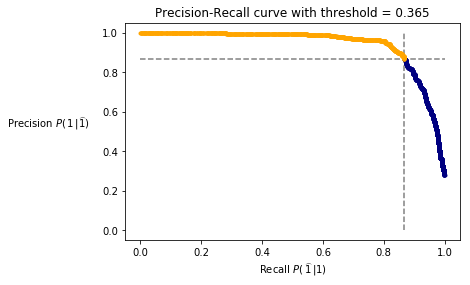

In [314]:
probas = classifier.predict_proba(X_train)[:, 1]

precision_recall_curve_with_threshold(y_train, probas, threshold = 0.365)

In [315]:
probs = classifier.predict_proba(X_train)[:, 1] 
preds = [int(prob > 0.365) for prob in probs]
y_predict_train = preds

acc = metrics.accuracy_score(y_train, y_predict_train)
rec = metrics.recall_score(y_train, y_predict_train)
prc = metrics.precision_score(y_train, y_predict_train)
spe = specificity_score(y_train, y_predict_train)
f1  = metrics.f1_score(y_train, y_predict_train)

print('Accuracy : {:.2f}%'.format(acc*100))
print('Recall : {:.2f}%'.format(rec*100))
print('Precision : {:.2f}%'.format(prc*100))
print('Specificity : {:.2f}%'.format(spe*100))
print('F1-score : {:.2f}%'.format(f1*100))

Accuracy : 94.14%
Recall : 86.68%
Precision : 86.68%
Specificity : 96.24%
F1-score : 86.68%


In [322]:
classifier_metrics(y_test = y_train, y_preds = [int(prob > 0.365) for prob in probs], average='macro')

Accuracy : 94.14%
Recall : 91.46%
Precision : 91.46%
F1-score : 91.46%


## Random Forest Feature Importance

In [323]:
def rf_feat_importance(model, df):
    feat_importance = pd.DataFrame({
        'cols': df.columns, 
        'imp': model.feature_importances_,
    })
    feat_importance = feat_importance.sort_values('imp', ascending = False)
    return feat_importance


def rf_unfolded_feat_importance(model, df):
    feat_importance = pd.DataFrame({
        'cols': df.columns, 
        'imp': model.feature_importances_,
    })
    for i, tree in enumerate(model.estimators_):
        feat_importance['imp_' + str(i)] = tree.feature_importances_
    feat_importance = feat_importance.sort_values('imp', ascending = False)
    return feat_importance


# found at
# https://stackoverflow.com/questions/49170296/scikit-learn-feature-importance-calculation-in-decision-trees
def tree_feature_importance(model, normalize = True):

    left_c = model.tree_.children_left
    right_c = model.tree_.children_right

    impurity = model.tree_.impurity    
    node_samples = model.tree_.weighted_n_node_samples 

    # Initialize the feature importance, those not used remain zero
    feature_importance = np.zeros((model.tree_.n_features,))

    for idx, node in enumerate(model.tree_.feature):
        if node >= 0:
            # Accumulate the feature importance over all the nodes where it's used
            feature_importance[node] += (
                impurity[idx]*node_samples[idx] -
                impurity[left_c[idx]]*node_samples[left_c[idx]] -
                impurity[right_c[idx]]*node_samples[right_c[idx]])

    # Number of samples at the root node
    feature_importance /= node_samples[0]

    if normalize:
        normalizer = feature_importance.sum()
        if normalizer > 0:
            feature_importance /= normalizer

    return feature_importance

In [325]:
classifier = RandomForestClassifier(
    n_estimators = 60, 
    class_weight = None, # classifier specific
    criterion = 'gini',  # classifier specific
    max_depth = 5, 
    min_samples_split = 58, 
    min_samples_leaf = 1, 
    min_weight_fraction_leaf = 0.0, 
    max_features = 0.21, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    min_impurity_split = None, 
    ccp_alpha = 0.0, 
    random_state = 42, 
    bootstrap = True, 
    oob_score = False, 
    max_samples = None,
    warm_start = False, 
    n_jobs = -1, 
    verbose = 0, 
    )
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=0.21, min_samples_split=58,
                       n_estimators=60, n_jobs=-1, random_state=42)

In [326]:
classifier.feature_importances_

array([3.88934580e-02, 4.05826973e-02, 7.37700109e-02, 4.25859217e-01,
       3.37743007e-03, 0.00000000e+00, 5.39731551e-04, 1.68541327e-03,
       9.51923616e-03, 5.03750261e-02, 2.44921432e-03, 5.92107112e-03,
       2.44500213e-02, 4.04229797e-02, 1.87612974e-02, 1.43298049e-02,
       1.73637317e-02, 5.09349318e-03, 2.66918828e-03, 1.28507146e-02,
       1.81284289e-02, 2.38587366e-02, 0.00000000e+00, 3.02271556e-03,
       2.56839521e-03, 1.03894327e-02, 1.37180915e-02, 1.42547171e-02,
       0.00000000e+00, 1.73074214e-04, 7.24879036e-03, 1.17721964e-01,
       1.91693599e-06])

In [437]:
feat_importance = rf_feat_importance(classifier, X_train)
feat_importance[:35]

,cols,imp
3,speed,0.425859
31,hour,0.117722
2,TV/h,0.073770
9,Dayofweek,0.050375
1,PL/h,0.040583
13,Vitesse du vent moyen 10 mn,0.040423
0,VL/h,0.038893
12,Variation de pression en 3 heures,0.024450
21,Etat du sol,0.023859
14,Température,0.018761


In [333]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [334]:
classifier = RandomForestClassifier(
    n_estimators = 60, 
    class_weight = None, # classifier specific
    criterion = 'gini',  # classifier specific
    max_depth = 5, 
    min_samples_split = 58, 
    min_samples_leaf = 1, 
    min_weight_fraction_leaf = 0.0, 
    max_features = 0.21, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    min_impurity_split = None, 
    ccp_alpha = 0.0, 
    random_state = 42, 
    bootstrap = True, 
    oob_score = False, 
    max_samples = None,
    warm_start = False, 
    n_jobs = -1, 
    verbose = 0, 
    )

global_results = dict()

for k in range(1, len(feat_importance)):
    
    f1, f1_CV= [], []
    
    to_keep = feat_importance.iloc[:k].cols
    df_keep = df_lapil42[to_keep].copy()

    n_total = len(df_keep)
    n_valid = 1500  
    n_train = n_total - n_valid

    X_train_keep, X_valid_keep = split_vals(df_keep, n_train)
    y_train, y_valid = split_vals(y, n_train)
    
    classifier.fit(X_train_keep, y_train)
    CV_score = cross_val_score(classifier, X_train_keep, y_train, scoring="f1", cv = 7).mean()
    y_predict_train = classifier.predict(X_train_keep)
    score = metrics.f1_score(y_train, y_predict_train)
    
    global_results[k] = [CV_score, score]

df_results = pd.DataFrame.from_dict(global_results)
df_results.index = ['CV', 'classic']
display_all(df_results)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
CV,0.762487,0.800852,0.797545,0.811845,0.786111,0.744030,0.757153,0.716232,0.697571,0.736744,0.753395,0.731205,0.731627,0.688285,0.682595,0.718192,0.673912,0.712431,0.683022,0.718813,0.719705,0.706033,0.704131,0.707572,0.705454,0.720504,0.693222,0.652746,0.691651,0.683754,0.696817,0.665921
classic,0.800367,0.839245,0.851025,0.851936,0.852847,0.844779,0.854378,0.836676,0.819656,0.849263,0.865922,0.863658,0.845757,0.854693,0.863744,0.864289,0.855787,0.860113,0.841185,0.856879,0.857944,0.854831,0.857543,0.864486,0.859135,0.863615,0.854846,0.863551,0.865893,0.856464,0.864037,0.863828


Garder Uniquement 11 variables semblerait pertinent.

## Permutation importance

In [415]:
classifier = RandomForestClassifier(
    n_estimators = 60, 
    class_weight = None, # classifier specific
    criterion = 'gini',  # classifier specific
    max_depth = 5, 
    min_samples_split = 58, 
    min_samples_leaf = 1, 
    min_weight_fraction_leaf = 0.0, 
    max_features = 0.21, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    min_impurity_split = None, 
    ccp_alpha = 0.0, 
    random_state = 42, 
    bootstrap = True, 
    oob_score = False, 
    max_samples = None,
    warm_start = False, 
    n_jobs = -1, 
    verbose = 0, 
    )
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=0.21, min_samples_split=58,
                       n_estimators=60, n_jobs=-1, random_state=42)

In [417]:
from sklearn.inspection import permutation_importance

In [419]:
result = permutation_importance(
    classifier, 
    X_train, 
    y_train, 
    n_repeats = 10,
    random_state = 42, n_jobs = -1,
)
sorted_idx = result.importances_mean.argsort()

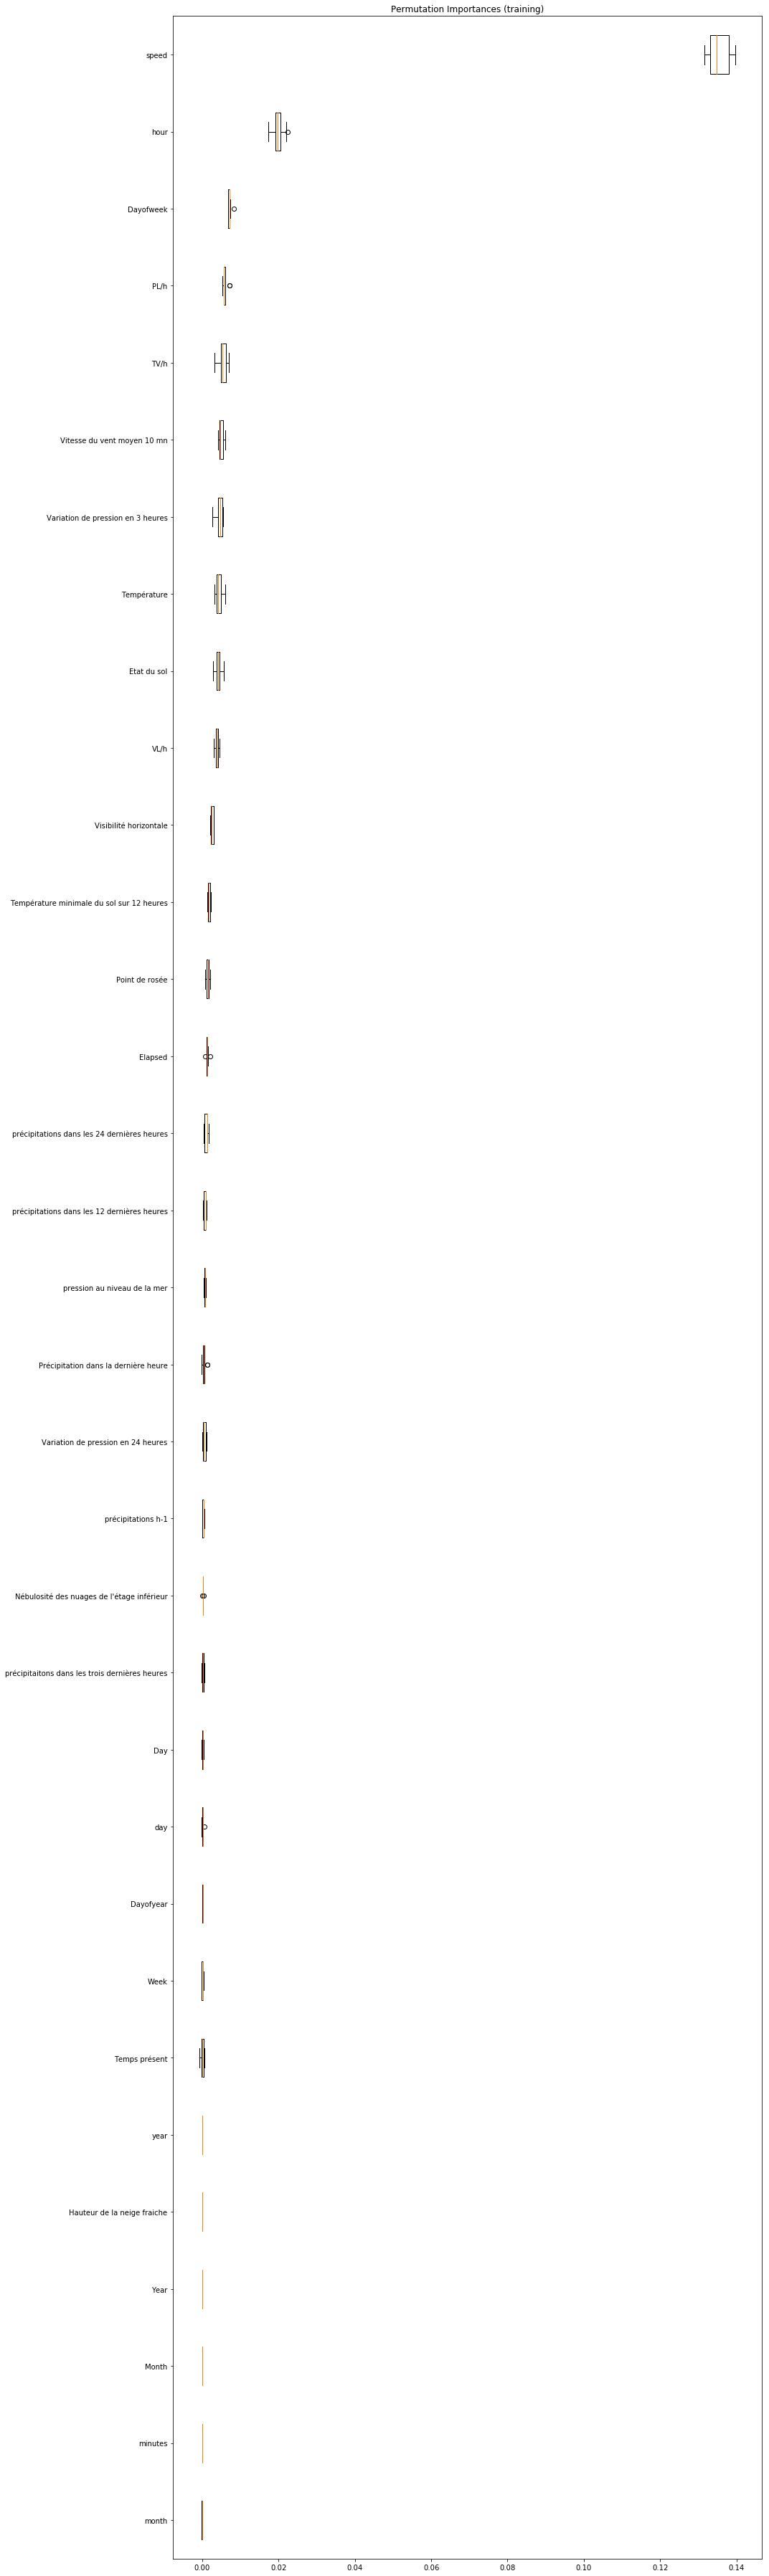

In [426]:
fig, ax = plt.subplots(figsize = (15, 50))
ax.boxplot(
    result.importances[sorted_idx].T,
    vert = False, 
    labels = X_train.columns[sorted_idx],
)
ax.set_title("Permutation Importances (training)")
fig.tight_layout()
plt.show()

In [438]:
X_train.columns[sorted_idx][1:]

Index(['minutes', 'Month', 'Year', 'Hauteur de la neige fraiche', 'year',
       'Temps présent', 'Week', 'Dayofyear', 'day', 'Day',
       'précipitaitons dans les trois dernières heures',
       'Nébulosité des nuages de l'étage inférieur', 'précipitations h-1',
       'Variation de pression en 24 heures',
       'Précipitation dans la dernière heure', 'pression au niveau de la mer',
       'précipitations dans les 12 dernières heures',
       'précipitations dans les 24 dernières heures', 'Elapsed',
       'Point de rosée', 'Température minimale du sol sur 12 heures',
       'Visibilité horizontale', 'VL/h', 'Etat du sol', 'Température',
       'Variation de pression en 3 heures', 'Vitesse du vent moyen 10 mn',
       'TV/h', 'PL/h', 'Dayofweek', 'hour', 'speed'],
      dtype='object')

In [440]:
classifier = RandomForestClassifier(
    n_estimators = 60, 
    class_weight = None, # classifier specific
    criterion = 'gini',  # classifier specific
    max_depth = 5, 
    min_samples_split = 58, 
    min_samples_leaf = 1, 
    min_weight_fraction_leaf = 0.0, 
    max_features = 0.21, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    min_impurity_split = None, 
    ccp_alpha = 0.0, 
    random_state = 42, 
    bootstrap = True, 
    oob_score = False, 
    max_samples = None,
    warm_start = False, 
    n_jobs = -1, 
    verbose = 0, 
    )

global_results = dict()

for k in range(1, len(X_train.columns[sorted_idx])):
    f1, f1_CV= [], []
    
    to_keep = X_train.columns[sorted_idx][k:]
    df_keep = df_lapil42[to_keep].copy()

    n_total = len(df_keep)
    n_valid = 1500  
    n_train = n_total - n_valid

    X_train_keep, X_valid_keep = split_vals(df_keep, n_train)
    y_train, y_valid = split_vals(y, n_train)
    
    classifier.fit(X_train_keep, y_train)
    CV_score = cross_val_score(classifier, X_train_keep, y_train, scoring="f1", cv = 7).mean()
    y_predict_train = classifier.predict(X_train_keep)
    score = metrics.f1_score(y_train, y_predict_train)
    
    global_results[k] = [CV_score, score]

df_results = pd.DataFrame.from_dict(global_results)
df_results.index = ['CV', 'classic']
display_all(df_results)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
CV,0.683879,0.675089,0.698538,0.695750,0.653679,0.686476,0.697413,0.695479,0.716593,0.684791,0.709035,0.723551,0.707084,0.687388,0.698602,0.702377,0.707205,0.722209,0.683712,0.700752,0.732786,0.754299,0.756535,0.703336,0.735582,0.733080,0.762377,0.782759,0.786579,0.787695,0.802766,0.762487
classic,0.864462,0.859142,0.851765,0.862197,0.863894,0.865769,0.863489,0.854215,0.851282,0.862085,0.857936,0.867281,0.854621,0.853333,0.865602,0.849673,0.854323,0.863636,0.838491,0.851958,0.856744,0.854215,0.852612,0.838114,0.845322,0.847521,0.849100,0.845941,0.837102,0.834791,0.836380,0.800367


Les résultats semblent moins pertinents ici.

## Conclusion

Nous allons garder les 11 variables qui apparaissent comme les plus importantes pour le modèle de fôret aléatoire. Il semblerait que ce soit le meilleur équilibre en terme de résultat (F1) et du nombre de variables explicatives.

In [464]:
to_keep = feat_importance.iloc[:11].cols
df_keep = df_lapil42[to_keep].copy()
df_keep['date'] = df_lapil42['date']
df_keep['congestion+30min'] = df_lapil42['congestion+30min']

In [465]:
df_keep

,speed,hour,TV/h,Dayofweek,PL/h,Vitesse du vent moyen 10 mn,VL/h,Variation de pression en 3 heures,Etat du sol,Température,Température minimale du sol sur 12 heures,date,congestion+30min
0,87.0,0,434.0,0,141.0,2.700000,293.0,80.000000,1.000000,287.950000,286.450000,2019-09-23 00:00:00,0
1,87.0,0,434.0,0,141.0,2.672726,293.0,76.713049,0.997336,287.919104,286.424860,2019-09-23 00:06:00,1
2,87.0,0,520.0,0,170.0,2.642294,350.0,73.491523,0.995162,287.886406,286.398089,2019-09-23 00:12:00,0
3,87.0,0,520.0,0,170.0,2.608704,350.0,70.335422,0.993478,287.851905,286.369686,2019-09-23 00:18:00,0
4,86.0,0,390.0,0,120.0,2.571957,270.0,67.244747,0.992285,287.815602,286.339653,2019-09-23 00:24:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6715,88.0,23,520.0,6,110.0,2.652161,410.0,201.973674,1.001384,283.560409,282.890517,2019-10-20 23:30:00,1
6716,85.0,23,690.0,6,140.0,2.650523,550.0,197.604785,1.001217,283.553549,282.858177,2019-10-20 23:36:00,1
6717,90.0,23,590.0,6,120.0,2.644488,470.0,193.222973,1.000995,283.549078,282.827955,2019-10-20 23:42:00,1
6718,86.0,23,510.0,6,100.0,2.634056,410.0,188.828238,1.000718,283.546996,282.799852,2019-10-20 23:48:00,1


In [466]:
df_keep.to_csv('data/LAPIL42_final_selection.csv', index = False)